# Titanic Analysis

#Martin Samouiller
#May 30,2017


In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import seaborn as sns
import re

# Going to use these 5 base models for the stacking
import sklearn
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

%matplotlib inline



In [2]:
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Remplace / Clean

In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction
#train = train.drop(['PassengerId','Name','Ticket'], axis=1)

full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""


# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;
    
    


# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp']
test  = test.drop(drop_elements, axis = 1)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Essai sans faire de test set :

In [50]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


df_x = train.drop("Survived", axis=1)
df_y = train["Survived"].copy()

rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf.fit(df_x, df_y)


#test sur le test_set qui provient du train : 
#print('Score : ' , random_forest.score(test_set_x, test_set_labels))

#a = cross_val_score(random_f_clf, df_x, df_y, cv=10, scoring="accuracy")


0.8272


In [57]:
print("OOB Score : %.4f" % rf.oob_score_)

print('Score : ' , rf.score(df_x, df_y))

#print('Features importances : ', rf.feature_importances_)

OOB Score : 0.8272
Score :  0.903479236813


In [56]:
X_test  = test.drop('PassengerId',axis=1).copy()
Y_pred = rf.predict(X_test)

submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)

In [6]:
from sklearn.model_selection import train_test_split
#random selection : maybe use stratified sample ?? 
train_set, test_set = train_test_split(train, test_size=0.05, random_state=42)

print('Train size : ' , train_set.shape)
print('Test size :' , test_set.shape)

train_set_copy = train_set.copy()
train_set.head(3)

Train size :  (846, 12)
Test size : (45, 12)


,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
86,0,3,1,0,3,3,0,22,0,5,0,1
67,0,3,1,1,0,1,0,24,0,1,1,1
350,0,3,1,1,0,1,0,22,0,1,1,1


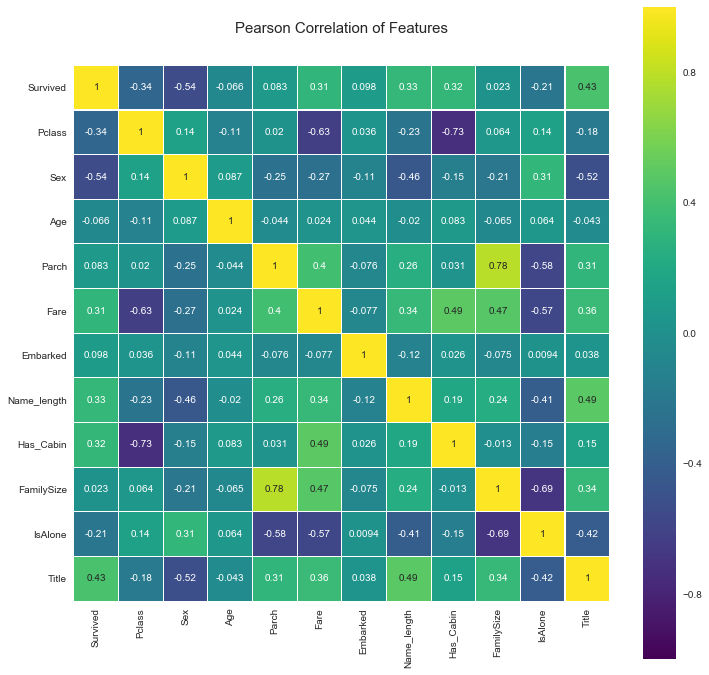

In [7]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_set.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [8]:
#correlation matrice
from pandas.tools.plotting import scatter_matrix
import seaborn as sns # relies on matplotlib

corr_matrix = train_set.corr()
print('Matrix correlation')
print(corr_matrix["Survived"].sort_values(ascending=False))

Matrix correlation
Survived       1.000000
Title          0.427379
Name_length    0.329802
Has_Cabin      0.322588
Fare           0.307563
Embarked       0.098274
Parch          0.083456
FamilySize     0.022676
Age           -0.066315
IsAlone       -0.211254
Pclass        -0.343225
Sex           -0.544038
Name: Survived, dtype: float64


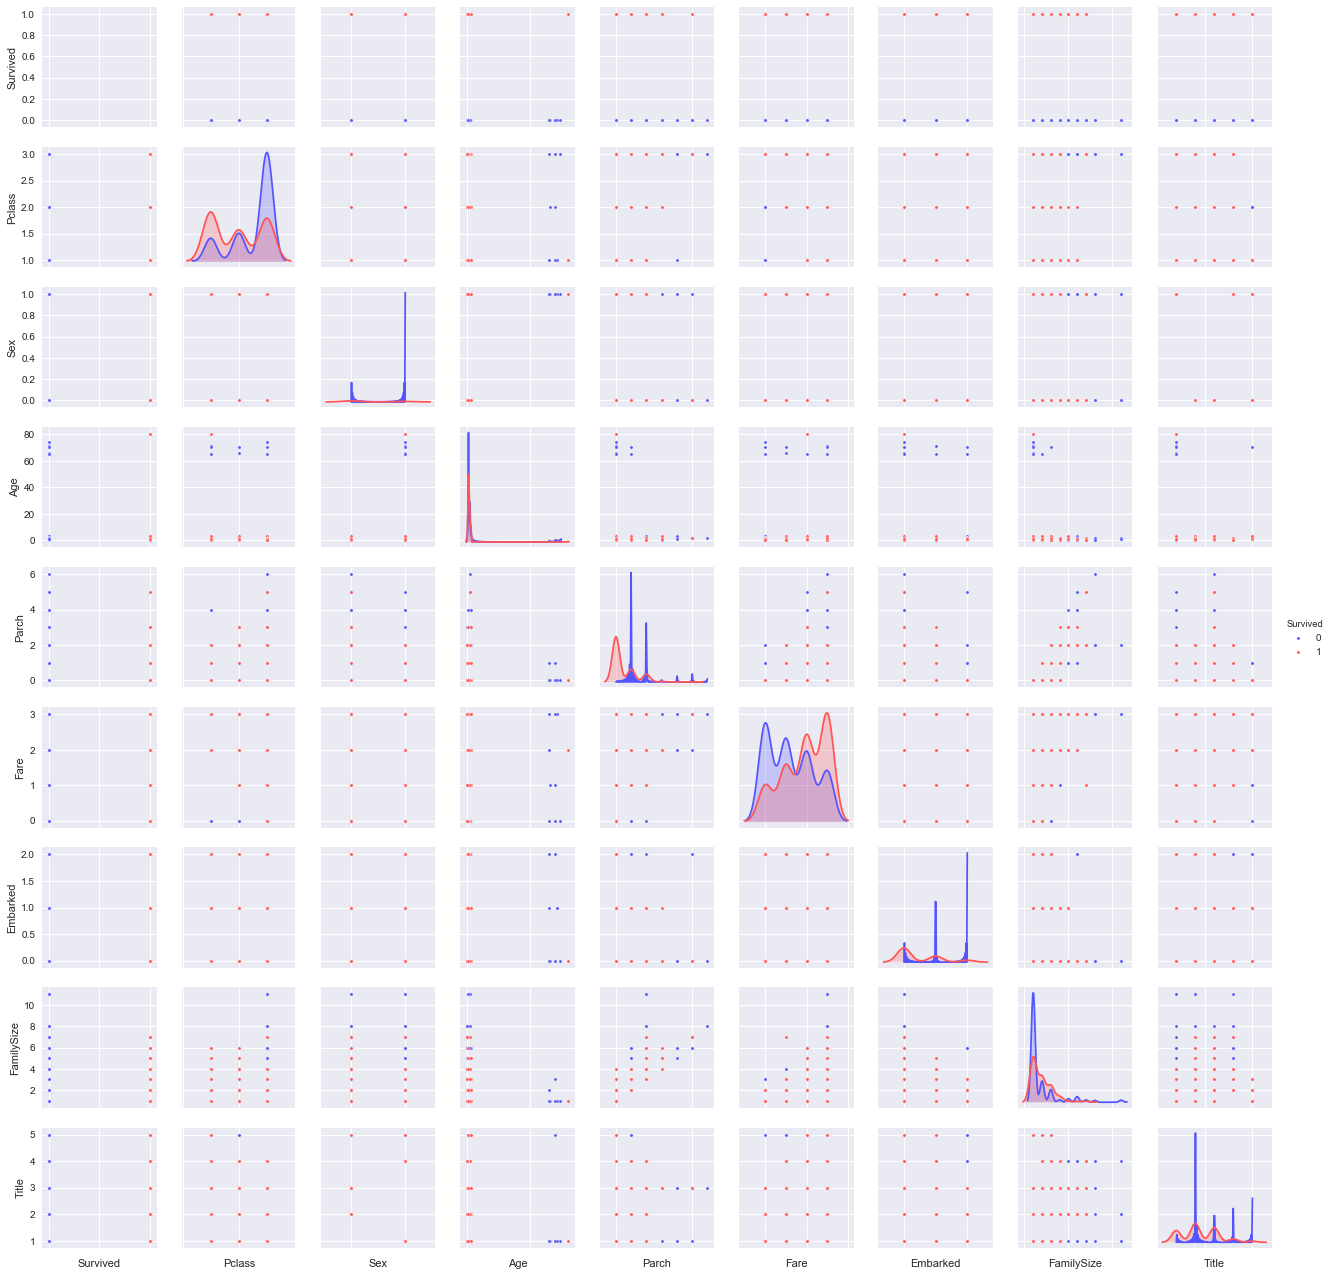

In [20]:
#kind="reg"
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )

g.set(xticklabels=[])




# Machine Learning algorithms

In [10]:
train_set_x = train_set.drop("Survived", axis=1)
train_set_labels = train_set["Survived"].copy()

test_set_x = test_set.drop("Survived", axis=1)
test_set_labels = test_set["Survived"].copy()

In [11]:
# machine learning
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(train_set_x, train_set_labels)
print('Score : ' , logreg.score(train_set_x, train_set_labels))

some_data = train_set_x.iloc[:5]
some_labels = train_set_labels.iloc[:5]

some_labels_prediction = logreg.predict(some_data)

print("Predictions:\t", some_labels_prediction)
print("Labels:\t\t", list(some_labels))

#test sur le test_set qui provient du train : 
print('Score : ' , logreg.score(test_set_x, test_set_labels))

Score :  0.802600472813
Predictions:	 [0 0 0 0 0]
Labels:		 [0, 0, 0, 0, 0]
Score :  0.755555555556


In [47]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=70)

tree_clf.fit(df_x, df_y)

print('Score : ' , tree_clf.score(df_x, df_y))

#test sur le test_set qui provient du train : 
print('Score : ' , tree_clf.score(test_set_x, test_set_labels))


Score :  0.967452300786
Score :  0.955555555556


In [43]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=1000)
random_forest.fit(train_set_x, train_set_labels)

print('Score : ' , random_forest.score(train_set_x, train_set_labels))

#test sur le test_set qui provient du train : 
print('Score : ' , random_forest.score(test_set_x, test_set_labels))


Score :  0.968085106383
Score :  0.866666666667


In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42, n_estimators=2000)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
        estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='soft'
    )
voting_clf.fit(train_set_x, train_set_labels)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(train_set_x, train_set_labels)
    y_pred = clf.predict(test_set_x)
    print(clf.__class__.__name__, accuracy_score(test_set_labels, y_pred))

LogisticRegression 0.755555555556
RandomForestClassifier 0.844444444444
SVC 0.777777777778
VotingClassifier 0.8


In [48]:
X_test  = test.drop('PassengerId',axis=1).copy()
Y_pred = tree_clf.predict(X_test)

submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)

In [16]:
#Parch          0.078311
#FamilySize     0.003565
#Age           -0.038163
#IsAlone       -0.180542
"""drop_elements = ['Survived','Parch', 'Age', 'IsAlone']
train_s_x = train_set.drop(drop_elements, axis=1)
train_s_y = train_set["Survived"].copy()

test_s_x = test_set.drop(drop_elements, axis=1)
test_s_y = test_set["Survived"].copy()

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train_s_x, train_s_y)

print('Score : ' , random_forest.score(train_s_x, train_s_y))

#test sur le test_set qui provient du train : 
print('Score : ' , random_forest.score(test_s_x, test_s_y))"""

u'drop_elements = [\'Survived\',\'Parch\', \'Age\', \'IsAlone\']\ntrain_s_x = train_set.drop(drop_elements, axis=1)\ntrain_s_y = train_set["Survived"].copy()\n\ntest_s_x = test_set.drop(drop_elements, axis=1)\ntest_s_y = test_set["Survived"].copy()\n\nrandom_forest = RandomForestClassifier(n_estimators=100)\nrandom_forest.fit(train_s_x, train_s_y)\n\nprint(\'Score : \' , random_forest.score(train_s_x, train_s_y))\n\n#test sur le test_set qui provient du train : \nprint(\'Score : \' , random_forest.score(test_s_x, test_s_y))'

In [17]:
# Generate Submission File 
"""drop_elements = ['PassengerId', 'Parch',  'Age', 'IsAlone']
X_test  = test.drop(drop_elements,axis=1).copy()
X_test.head()

Y_pred = random_forest.predict(X_test)

submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)"""

u'drop_elements = [\'PassengerId\', \'Parch\',  \'Age\', \'IsAlone\']\nX_test  = test.drop(drop_elements,axis=1).copy()\nX_test.head()\n\nY_pred = random_forest.predict(X_test)\n\nsubmission = pd.DataFrame({\n        "PassengerId": test["PassengerId"],\n        "Survived": Y_pred\n    })\nsubmission.to_csv(\'titanic.csv\', index=False)'